<a href="https://colab.research.google.com/github/nebuchadnezzarr/DL-ML/blob/master/Classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###IMPORTING MODULES


In [0]:
!pip install python-resize-image

     |████████████████████████████████| 2.0MB 6.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
import keras                                                 #библиотека для построения модели
from keras.models import Sequential                          #тип модели
from keras.layers import Conv2D, Dense, Flatten, Activation  #слои для нейронной сети, которые будем использовать
from keras.layers import MaxPooling2D, Dropout, BatchNormalization
import numpy as np  
import os                                                    #для манипуляций с файлами (чтение и т.п.)
import cv2                                                   #для преобразования картинок в матрицы
import matplotlib.pyplot as plt                              #примерно похожа на предыдущее, но иногда работает лучше 
from keras.preprocessing.image import ImageDataGenerator     #помогает закидывать данные в сеть
from PIL import Image
from resizeimage import resizeimage
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools
import random
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import model_from_yaml


###DATA LOAD

In [0]:
#Здесь мы подключаем папку гугл диска, чтобы получить доступ к архиву датасета
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
!unzip -q /content/gdrive/'My Drive'/my_set/set.zip -d my_set

In [0]:
%cd my_set/

/content/my_set


In [0]:
 #Есть 2 папки: одна для тренировки, другая для валидации, внутри них еще по 2 папки, соответствующие нужным классам
!ls
!ls test/
!ls train/

test  train
bikes  planes
bikes  planes


###MODEL

In [0]:
model = Sequential() #Указываем тип расстановки слоев (здесь - последовательный)

#Далее последовательно указываются слои в нашей сети

model.add(Conv2D(32, (5, 5), input_shape = (224, 224, 3), activation = 'relu')) #входной слой, принимает цветные картинки 224х224 (а если будут больше, то сеть их сожмет до такого размера)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (5, 5), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu')) #полносвязный слой
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid')) #выходной слой

In [0]:
Adam = keras.optimizers.Adam(lr = 0.0001) #Выбор оптимизатора градиентного спуска типа Адам
model.compile(optimizer = Adam, loss = 'binary_crossentropy', metrics = ['accuracy']) #Компилируем полученную модель

In [0]:
model.summary() #Вывод содержимого модели

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 109, 109, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
__________

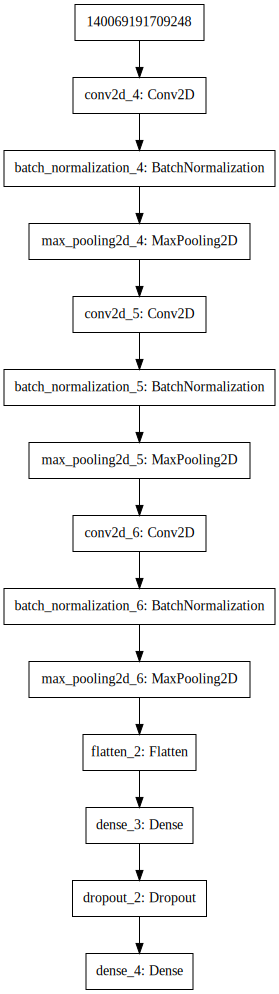

In [0]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
yaml_string = model.to_yaml()
print(yaml_string)

backend: tensorflow
class_name: Sequential
config:
  layers:
  - class_name: Conv2D
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {}
      bias_regularizer: null
      data_format: channels_last
      dilation_rate: &id002 !!python/tuple [1, 1]
      dtype: float32
      filters: 32
      kernel_constraint: null
      kernel_initializer:
        class_name: VarianceScaling
        config: {distribution: uniform, mode: fan_avg, scale: 1.0, seed: null}
      kernel_regularizer: null
      kernel_size: !!python/tuple [5, 5]
      name: conv2d_4
      padding: valid
      strides: &id003 !!python/tuple [1, 1]
      trainable: true
      use_bias: true
  - class_name: BatchNormalization
    config:
      axis: -1
      beta_constraint: null
      beta_initializer:
        class_name: Zeros
        config: {}
      bet

###MODEL LEARN

In [0]:
train_datagen = ImageDataGenerator( #создание объекта, задающего параметры аугментации для тренировки
            rescale = 1./255, #В нейронах будут храниться строго числа от 1 до 255
            shear_range = 0.2, #Во сколько раз максимально картинка может сдвинуться при аугментации
            zoom_range = 0.2, #Во сколько раз максимально может измениться приближение картинки
            horizontal_flip = True, #Горизонатльное отражение при аугментации разрешено
            vertical_flip = True, #Вертикальное отображение при аугментации разрешено
            brightness_range = (0.2, 0.5)) #Изменение яркости при аугментации находится в пределах от 0,2 до 0,5 раз

train_set = train_datagen.flow_from_directory( #создание списка бачей для тренировки
            '/content/my_set/train', #место хранения тренировочного сета
            target_size = (224, 224), #размер входных картинок
            color_mode = 'rgb', #принимаем на вход цветные изображения
            batch_size = 16, #в один пакет будем класть по 16 изображений
            class_mode = 'binary'
           ) #классифицируем только по 2 классам

test_datagen = ImageDataGenerator( #создание объекта, задающего параметры аугментации для валидации
            rescale = 1./255)

test_set = test_datagen.flow_from_directory( #создание списка бачей для валидации
            '/content/my_set/test', #место хранения валидационного сета
            target_size = (224, 224), 
            color_mode = 'rgb', 
            batch_size = 16,
            class_mode = 'binary',
            shuffle=False
            )

Found 1331 images belonging to 2 classes.
Found 267 images belonging to 2 classes.


In [0]:
model.fit_generator(train_set, steps_per_epoch = 84, validation_data = test_set, validation_steps = 17, epochs = 20)
#Команда для начала тренировки сети. 
#Количество шагов за эпоху равно суммарному количеству картинок / каоличество картинок в одном баче (это нужно, чтобы за одну эпоху обучение прошло по всем картинкам), то же касается шагов валидации

Epoch 1/20
84/84 [==============================] - 24s 286ms/step - loss: 0.0204 - acc: 0.9911 - val_loss: 0.3616 - val_acc: 0.9551
Epoch 2/20
84/84 [==============================] - 23s 272ms/step - loss: 0.0412 - acc: 0.9844 - val_loss: 0.2607 - val_acc: 0.9738
Epoch 3/20
84/84 [==============================] - 23s 275ms/step - loss: 0.0114 - acc: 0.9963 - val_loss: 0.1356 - val_acc: 0.9850
Epoch 4/20
84/84 [==============================] - 23s 273ms/step - loss: 0.0288 - acc: 0.9933 - val_loss: 0.0894 - val_acc: 0.9850
Epoch 5/20
84/84 [==============================] - 23s 272ms/step - loss: 0.0423 - acc: 0.9881 - val_loss: 0.0498 - val_acc: 0.9925
Epoch 6/20
84/84 [==============================] - 24s 284ms/step - loss: 0.0172 - acc: 0.9955 - val_loss: 0.2322 - val_acc: 0.9663
Epoch 7/20
84/84 [==============================] - 23s 274ms/step - loss: 0.0225 - acc: 0.9940 - val_loss: 0.1490 - val_acc: 0.9813
Epoch 8/20
84/84 [==============================] - 22s 266ms/step - 

In [0]:
addr = '/content/gdrive/' + 'My Drive' + '/my_set/my_weights.h5'
!rm /content/gdrive/'My Drive/my_set/my_weights.h5'
model.save_weights(addr)

###CONFUSION MATRIX

In [0]:
#Записываем данные
Y_pred = model.predict_generator(test_set, steps = 17)
y_pred = np.round(Y_pred, 0)
cm = confusion_matrix(test_set.classes, y_pred)
target_names = ['Bike', 'Plane']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Bike       0.96      1.00      0.98       133
       Plane       1.00      0.96      0.98       134

   micro avg       0.98      0.98      0.98       267
   macro avg       0.98      0.98      0.98       267
weighted avg       0.98      0.98      0.98       267



[[133   0]
 [  5 129]]
Confusion matrix, without normalisation


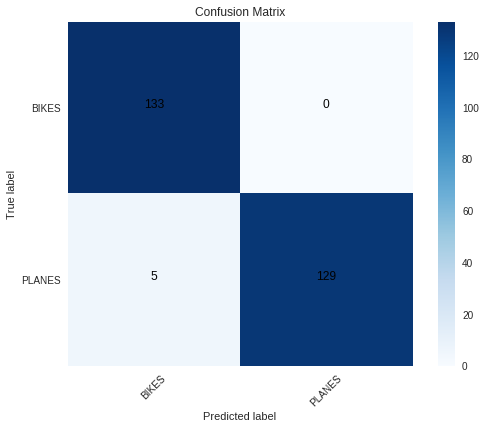

In [0]:
#Красиво оформляем и выводим
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalisation')
    
print(cm)

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, cm[i, j],
          horizontalalignment="center",
          color="black" if cm[i, j] > thresh else "black")
           
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.grid(False)
cm_plot_labels = ['BIKES', 'PLANES']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

###RANDOM PREDICT

In [0]:
#В этой секции взяты 10 произвольных картинок из интернета и протестированы на сети

In [0]:
#Расписываем адреса изначальных и уменьшенных файлов
addr = '/content/gdrive/' + 'My Drive' + '/my_set/random/'
addr_new = '/content/gdrive/' + 'My Drive' + '/my_set/random/small/'
!rm -Rf /content/gdrive/'My Drive'/my_set/random/small
!mkdir -p /content/gdrive/'My Drive'/my_set/random/small

In [0]:
#Подготовка к заброске в сеть, уменьшение размера
def out_res(i):
  pic =  addr + str(i) + '.jpg'
  pic_new = addr_new + str(i) + '.jpg'
  with open(pic, 'r+b') as f: #Сжимаем размер
      with Image.open(f) as image:
        cover = resizeimage.resize_cover(image, [224, 224], validate=False)
        cover.save(pic_new, image.format)
#Выводим на экран картинку
  img = plt.imread(pic_new)
  plt.imshow(img)
  img = np.expand_dims(img, 0)
  #Выводим результат работы сети
  if np.round(model.predict(img)) == 0:
    print('Motorbike')
  else:
    print('Aeroplane')

In [0]:
out_res(1)

OSError: ignored

Motorbike


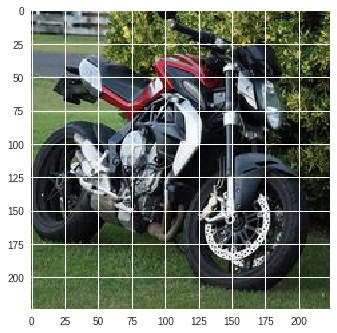

In [0]:
out_res(2)

Aeroplane


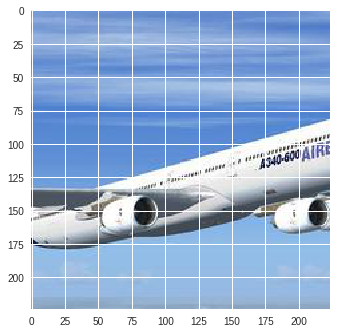

In [0]:
out_res(3)

Aeroplane


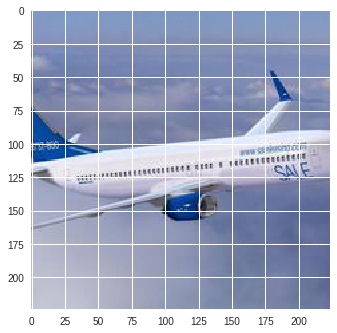

In [0]:
out_res(4)

Motorbike


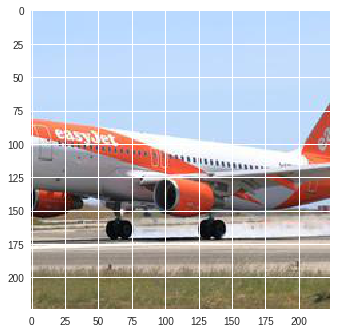

In [0]:
out_res(5)

Aeroplane


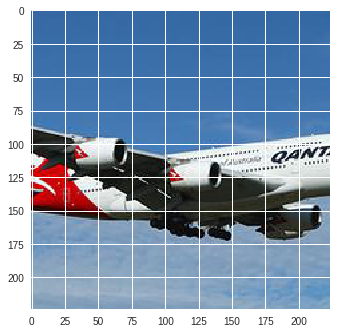

In [0]:
out_res(6)

Motorbike


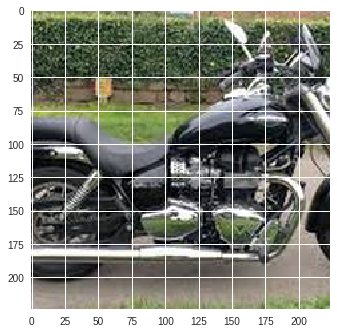

In [0]:
out_res(7)

Motorbike


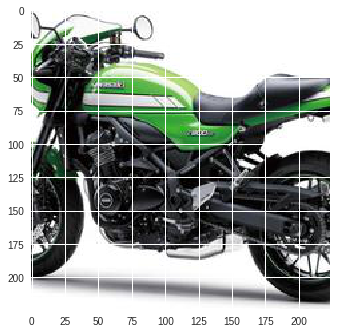

In [0]:
out_res(8)

Aeroplane


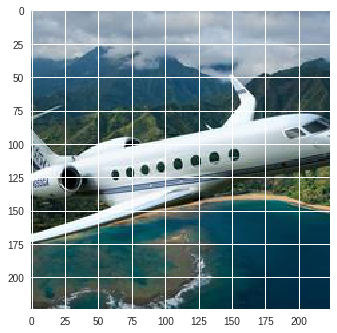

In [0]:
out_res(9)

Motorbike


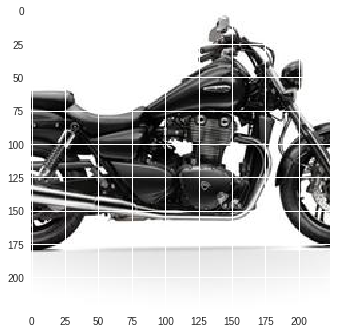

In [0]:
out_res(10)